In [1]:
#Импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#Загружаем таблицу с данными
df = pd.read_csv('flights.csv')

In [2]:
df.columns

Index(['arrival_latitude', 'arrival_longitude', 'arrival_airport',
       'actual_arrival', 'actual_departure', 'model', 'qnt_seat', 'sum_amount',
       'count_seat_no'],
      dtype='object')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   arrival_latitude   180 non-null    float64
 1   arrival_longitude  180 non-null    float64
 2   arrival_airport    180 non-null    object 
 3   actual_arrival     180 non-null    object 
 4   actual_departure   180 non-null    object 
 5   model              180 non-null    object 
 6   qnt_seat           180 non-null    int64  
 7   sum_amount         180 non-null    float64
 8   count_seat_no      180 non-null    int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 12.8+ KB


In [4]:
df.describe()

,arrival_latitude,arrival_longitude,qnt_seat,sum_amount,count_seat_no
count,180.000000,180.000000,180.000000,1.800000e+02,180.000000
mean,53.308199,37.002350,113.500000,1.179647e+06,101.950000
std,2.671832,0.413400,16.546025,4.811836e+05,14.423086
min,50.643799,36.590099,97.000000,5.310000e+05,64.000000
25%,50.643799,36.590099,97.000000,7.385250e+05,93.000000
50%,53.308199,37.002350,113.500000,1.068850e+06,97.000000
75%,55.972599,37.414600,130.000000,1.631950e+06,112.250000
max,55.972599,37.414600,130.000000,1.886000e+06,130.000000


In [5]:
df.head()

,arrival_latitude,arrival_longitude,arrival_airport,actual_arrival,actual_departure,model,qnt_seat,sum_amount,count_seat_no
0,55.972599,37.4146,SVO,2017-01-03T11:49:00Z,2017-01-03T10:08:00Z,Boeing 737-300,130,1653000.0,113
1,55.972599,37.4146,SVO,2017-02-24T11:46:00Z,2017-02-24T10:07:00Z,Boeing 737-300,130,1605400.0,109
2,55.972599,37.4146,SVO,2017-01-08T11:48:00Z,2017-01-08T10:08:00Z,Boeing 737-300,130,1431000.0,97
3,55.972599,37.4146,SVO,2017-02-13T11:46:00Z,2017-02-13T10:07:00Z,Boeing 737-300,130,1556600.0,107
4,55.972599,37.4146,SVO,2017-01-28T11:46:00Z,2017-01-28T10:07:00Z,Boeing 737-300,130,1812800.0,124


## Function

In [6]:
#Функция рассчета расстояния между двумя точками
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

## Calculate distance

In [7]:
#Рассчитываем растояние между аэропортами
aaq_lat, aaq_lon = 45, 37.35
distances_km = []
for row in df.itertuples(index=False):
   distances_km.append(
       haversine_distance(aaq_lat, aaq_lon, row.arrival_latitude, row.arrival_longitude)
   )
df['distance_km'] = distances_km

## Convert to datetime format

In [8]:
#Переводим данные в формат datetime и создаем колонки месяцы и дни недели
df['actual_arrival'] =  pd.to_datetime(df['actual_arrival'], format='%Y-%m-%dT%H:%M:%S.%f')
df['actual_departure'] =  pd.to_datetime(df['actual_departure'], format='%Y-%m-%dT%H:%M:%S.%f')
df['distance']=df.apply(lambda row: row.actual_arrival - row.actual_departure, axis=1)
df['month'] = pd.DatetimeIndex(df['actual_departure']).month
df['weekday'] = pd.DatetimeIndex(df['actual_departure']).weekday

## Aircraft load

In [9]:
#Считаем загрузку самолета
df['load']=df.apply(lambda row: row.count_seat_no * 100/ row.qnt_seat, axis=1)

<AxesSubplot:>

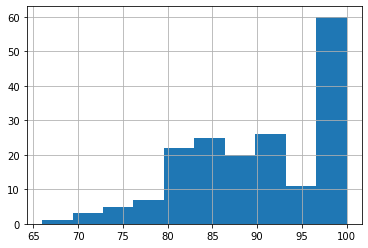

In [10]:
df.load.hist()

In [11]:
#Выведем данные с низкой загрузкой в отдельный датасет
low_load = df[df.load < 80]

In [12]:
#Посмотрим в какие дни недели самая низкая загрузка
#Это воскресенье, но в целом в данных нет ничего необычного
low_load.weekday.value_counts()

6    4
5    3
3    3
2    3
0    2
1    1
Name: weekday, dtype: int64

In [13]:
#Загрузка в феврале больше чем в декабре и январе, но в целом больших различий не наблюдается
low_load.month.value_counts()

12    6
1     6
2     4
Name: month, dtype: int64

In [14]:
#В Шереметьево летает больше самолетов с небольшим количеством пассажиров
low_load.arrival_airport.value_counts()

SVO    13
EGO     3
Name: arrival_airport, dtype: int64

In [15]:
#Максимально загруженные рейсы в четверг
df[df.load == df.load.max()].weekday.value_counts()

3    6
5    4
4    4
2    4
1    4
6    3
0    3
Name: weekday, dtype: int64

## Basic Data Analysis

#### Aircraft Model

In [16]:
#Модели самолетов не отличаются по количеству
df.model.value_counts()

Boeing 737-300         90
Sukhoi Superjet-100    90
Name: model, dtype: int64

#### Arrival Airport

In [17]:
#Аэропорты прибытия так же распределены одинаково
print(df.arrival_airport.value_counts())

EGO    90
SVO    90
Name: arrival_airport, dtype: int64


## Корреляционный анализ

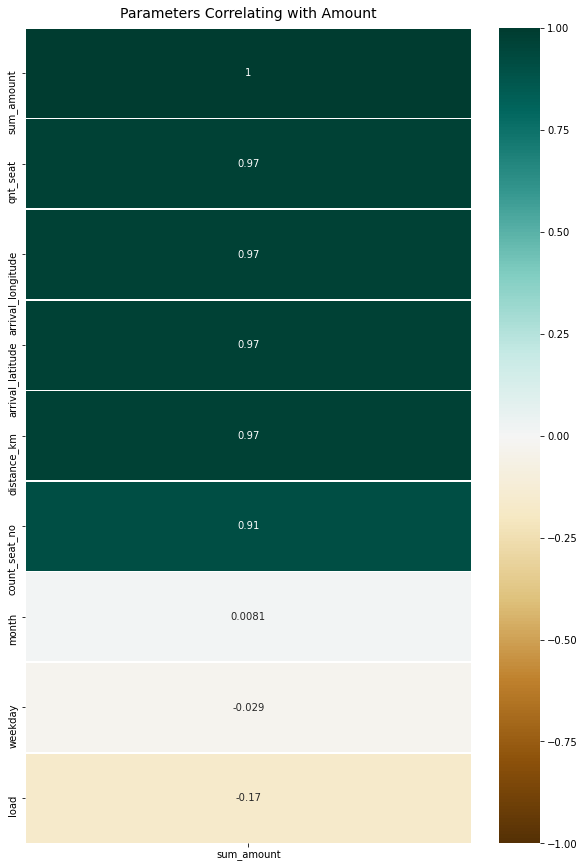

In [18]:
fig, ax = plt.subplots(figsize=(10,15))
heatmap = sns.heatmap(df.corr()[['sum_amount']].sort_values(by='sum_amount', ascending=False)
                      , vmin=-1, vmax=1, annot=True,linewidths=.5, ax=ax, cmap='BrBG')
heatmap.set_title('Parameters Correlating with Amount', fontdict={'fontsize':14}, pad=10);

### Итоги
В целом в данных не было обнаружено никаких заметных отклонений, на основании которых можно было бы сделать однозначные выводы, но в целом можно рассмотреть необходимость частных рейсов в аэропорт Шереметьево и проверить необходимость мало заполненных рейсов.